  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-k06kezeu
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-k06kezeu
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit f40a266a550e37ac16cb6c46dd29a6183f39f618
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


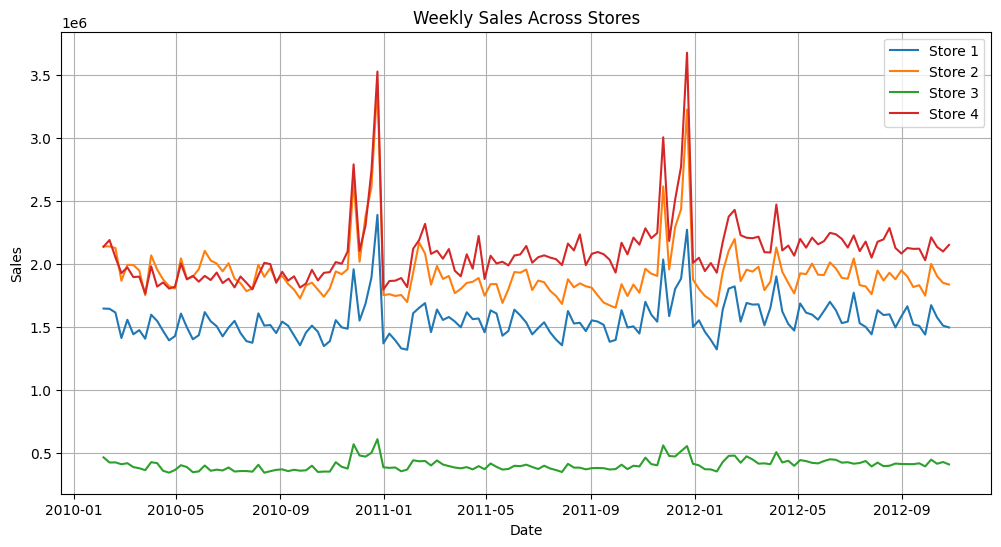

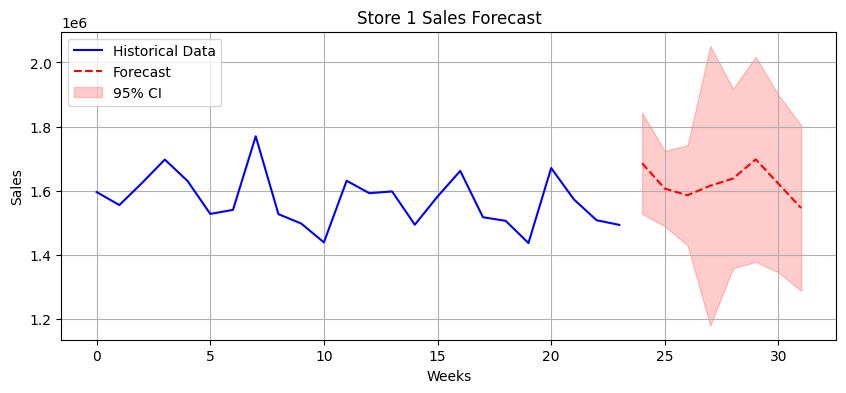

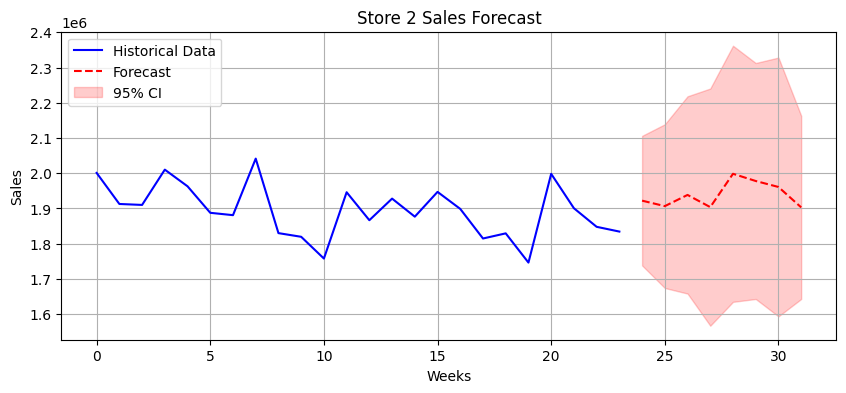

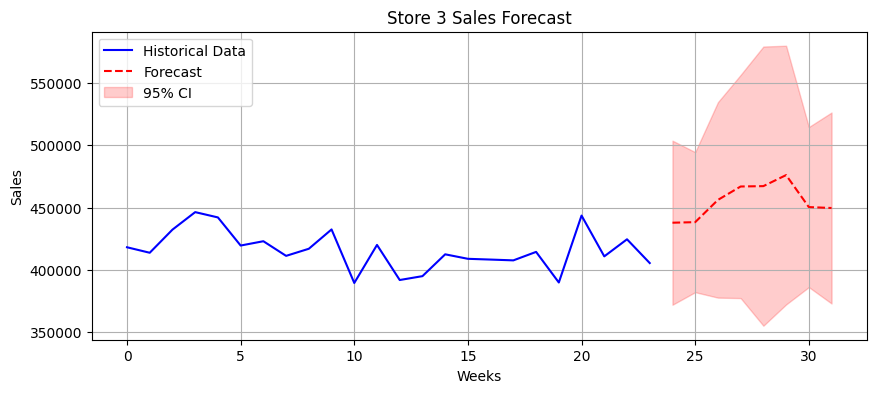

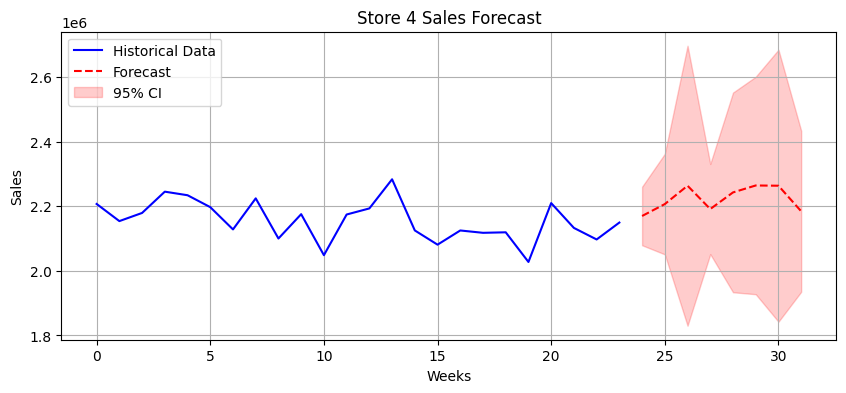

In [8]:
# Install required packages
!pip install git+https://github.com/amazon-science/chronos-forecasting.git
!pip install pandas matplotlib

import torch
import pandas as pd
import matplotlib.pyplot as plt
from chronos import ChronosPipeline

# Load the dataset (replace with your actual data path)
url = "https://raw.githubusercontent.com/marcopeix/FoundationModelsForTimeSeriesForecasting/main/data/walmart_sales_small.csv"
df = pd.read_csv(url, parse_dates=['Date'])

# Plot the data
plt.figure(figsize=(12, 6))
for store in df['Store'].unique():
    store_data = df[df['Store'] == store]
    plt.plot(store_data['Date'], store_data['Weekly_Sales'], label=f'Store {store}')
plt.title('Weekly Sales Across Stores')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

# Prepare data for Chronos
# Convert each store's series to a tensor
context = [torch.tensor(df.query("Store == @i")['Weekly_Sales'].to_numpy()) for i in range(1, 5)]

# Initialize Chronos pipeline (using small model for demo)
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cuda" if torch.cuda.is_available() else "cpu",
    torch_dtype=torch.bfloat16,
)

# Make predictions
prediction_length = 8  # 8 weeks forecast
num_samples = 20       # Number of samples for prediction intervals

predictions = pipeline.predict(
    context=context,
    prediction_length=prediction_length,
    num_samples=num_samples,
)

# Process and visualize predictions
def plot_predictions(store_idx, store_num):
    plt.figure(figsize=(10, 4))

    # Historical data
    history = df[df['Store'] == store_num]['Weekly_Sales'].values[-24:]  # Last 24 weeks
    plt.plot(range(len(history)), history, 'b-', label='Historical Data')

    # Predictions
    pred_mean = predictions[store_idx].mean(axis=0)  # Mean across samples
    pred_std = predictions[store_idx].std(axis=0)    # Std across samples

    # Prediction interval (95%)
    upper = pred_mean + 1.96 * pred_std
    lower = pred_mean - 1.96 * pred_std

    future_range = range(len(history), len(history) + prediction_length)
    plt.plot(future_range, pred_mean, 'r--', label='Forecast')
    plt.fill_between(future_range, lower, upper, color='red', alpha=0.2, label='95% CI')

    plt.title(f'Store {store_num} Sales Forecast')
    plt.xlabel('Weeks')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid()
    plt.show()

# Plot predictions for each store
for i in range(4):
    plot_predictions(i, i+1)

# Evaluation metrics (if test data available)
def evaluate_predictions(true_values, pred_mean):
    mae = torch.mean(torch.abs(torch.tensor(true_values) - torch.tensor(pred_mean)))
    mape = torch.mean(torch.abs((torch.tensor(true_values) - torch.tensor(pred_mean)) / torch.tensor(true_values))) * 100
    return mae.item(), mape.item()

# Example evaluation (would need actual future values)
# true_values = [...]  # Actual values for the forecast period
# mae, mape = evaluate_predictions(true_values, predictions[0].mean(axis=0))
# print(f"MAE: {mae:.2f}, MAPE: {mape:.2f}%")